In [11]:
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50V2, VGG16
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input, MaxPool2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Activation
from tensorflow.keras.models import Model
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
import os
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score
BATCH_SIZE = 64
test_path="/загрузки/test"
train_path="/загрузки/train"
INPUT_SHAPE = (256,256,3)

In [12]:
batch_size = 64
train_input_shape = (256, 256, 3)
test_path="/загрузки/test"
train_path="/загрузки/train"


class_names = ['Symbolism', 'Romanticism', 'Rococo', 
               'Renaissance',  'Realism', 'Expressionism', 
               'Japanese_Art', 'Baroque','Primitivism', 'Neoclassicism', 'Cubism']

def get_class_names(dataset_path):
    return [name for name in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, name))]

train_class_names = get_class_names(train_path)
test_class_names = get_class_names(test_path)


art_movements = pd.DataFrame({'names': class_names})


class_weights = {}
total_paintings = 0
for class_name in class_names:
    train_class_path = os.path.join(train_path, class_name)
    test_class_path = os.path.join(test_path, class_name)
    num_train_paintings = sum([len(files) for _, _, files in os.walk(train_class_path)])
    num_test_paintings = sum([len(files) for _, _, files in os.walk(test_class_path)])
    total_paintings += num_train_paintings + num_test_paintings

for i, class_name in enumerate(class_names):
    train_class_path = os.path.join(train_path, class_name)
    test_class_path = os.path.join(test_path, class_name)
    num_train_paintings = sum([len(files) for _, _, files in os.walk(train_class_path)])
    num_test_paintings = sum([len(files) for _, _, files in os.walk(test_class_path)])
    class_weights[i] = total_paintings / (len(class_names) * (num_train_paintings + num_test_paintings))


print("Class Weights:")
print(class_weights)
print("\nClass Names:")
print(class_names)
art_movements_name = art_movements['names'].values

Class Weights:
{0: 2.4026253918495297, 1: 0.5093595104256085, 2: 1.3372469194140526, 3: 0.6570637613859618, 4: 0.6486529374426969, 5: 1.3695555059191422, 6: 1.5541145657316662, 7: 0.6484014240896754, 8: 2.5298445880896714, 9: 1.143012489902442, 10: 1.604824637934043}

Class Names:
['Symbolism', 'Romanticism', 'Rococo', 'Renaissance', 'Realism', 'Expressionism', 'Japanese_Art', 'Baroque', 'Primitivism', 'Neoclassicism', 'Cubism']


In [13]:

train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=5,
    zoom_range=0.05,
    horizontal_flip=True,
    validation_split=0.1
)


validation_datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.1)


train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=train_input_shape[0:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training',
    seed=123,
    classes=art_movements_name.tolist()
)

validation_generator = validation_datagen.flow_from_directory(
    test_path,
    target_size=train_input_shape[0:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,  
    subset='validation',
    seed=123,
    classes=art_movements_name.tolist()
)


Found 26435 images belonging to 11 classes.
Found 737 images belonging to 11 classes.


In [14]:
Step_Train = train_generator.n//train_generator.batch_size
Step_Validation = validation_generator.n//validation_generator.batch_size
print("Total number of batches =", Step_Train, "and", Step_Validation)

Total number of batches = 413 and 11


In [15]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, 
                           mode='auto', restore_best_weights=True)


In [16]:

base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(256,256,3))


for layer in base_model.layers:
    layer.trainable = True


In [17]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
# from tensorflow.keras.optimizers import Adam

# # Определите свою модель CNN
# model = Sequential()
# model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(200, 200, 3)))
# model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dropout(0.15))
# model.add(Dense(100, activation='relu'))
# model.add(Dropout(0.15))
# model.add(Dense(50, activation='relu'))
# model.add(Dense(11, activation='softmax'))  
# model.summary()

In [18]:
from tensorflow.keras.layers import LeakyReLU

output = base_model.output
output = Flatten()(output)

output = Dense(512, kernel_initializer='he_uniform')(output)
output = Dropout(0.3)(output)
output = BatchNormalization()(output)
output = LeakyReLU(alpha=0.1)(output)

output = Dense(256, kernel_initializer='he_uniform')(output)
output = Dropout(0.3)(output)
output = BatchNormalization()(output)
output = LeakyReLU(alpha=0.1)(output)

output = Dense(128, kernel_initializer='he_uniform')(output)
output = Dropout(0.3)(output)
output = BatchNormalization()(output)
output = LeakyReLU(alpha=0.1)(output)

output = Dense(64, kernel_initializer='he_uniform')(output)
output = Dropout(0.3)(output)
output = BatchNormalization()(output)
output = LeakyReLU(alpha=0.1)(output)

output = Dense(32, kernel_initializer='he_uniform')(output)
output = BatchNormalization()(output)
output = LeakyReLU(alpha=0.1)(output)

output = Dense(11, activation='softmax')(output)

model = Model(inputs=base_model.inputs, outputs=output)

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 130, 130, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

In [19]:
adam = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'),    
                       tf.keras.metrics.Recall(name='recall')])  

In [20]:

history = model.fit(train_generator, 
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator), 
                    validation_steps=len(validation_generator),
                    epochs=30,
                    verbose=1,
                    callbacks=[reduce_lr, early_stop],
                    class_weight=class_weights
                   )



Epoch 1/30
272/414 [==================>...........] - ETA: 12:45 - loss: 2.1042 - accuracy: 0.2803 - precision: 0.7241 - recall: 0.0557

d:\Сириус\.venv\lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


414/414 [==============================] - 2257s 5s/step - loss: 1.9963 - accuracy: 0.3286 - precision: 0.7834 - recall: 0.0825 - val_loss: 1.8312 - val_accuracy: 0.4084 - val_precision: 0.6954 - val_recall: 0.1425 - lr: 1.0000e-04
Epoch 2/30
107/414 [======>.......................] - ETA: 27:15 - loss: 1.5654 - accuracy: 0.4955 - precision: 0.8601 - recall: 0.1721

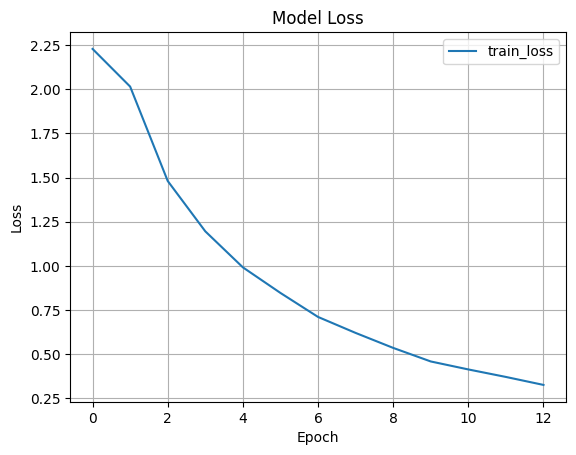

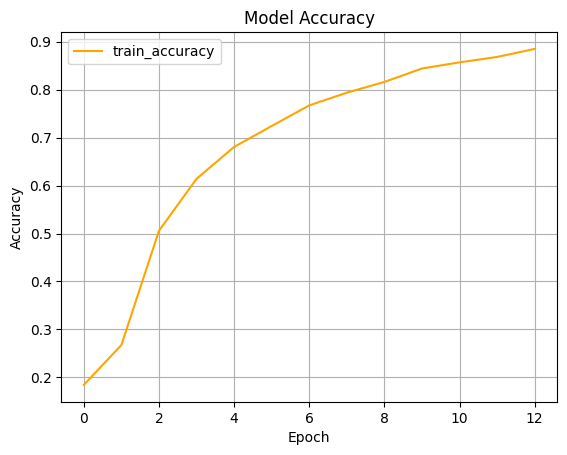

In [ ]:
import matplotlib.pyplot as plt

# Предоставленные данные обучения
train_loss = [2.2285, 2.0151, 1.4804, 1.1952, 0.9912, 0.8462, 0.7103, 0.6198, 0.5349, 0.4581, 0.4129, 0.3704, 0.3252]
train_accuracy = [0.1844, 0.2676, 0.5058, 0.6140, 0.6805, 0.7241, 0.7671, 0.7936, 0.8160, 0.8440, 0.8568, 0.8681, 0.8848]

# Создание графика для потерь
plt.plot(train_loss, label='train_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Создание графика для точности
plt.plot(train_accuracy, label='train_accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


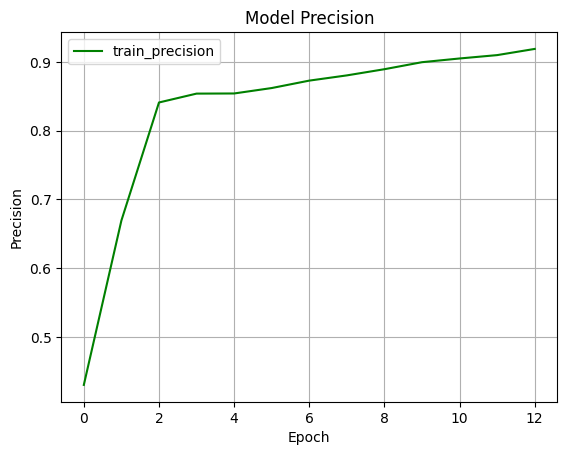

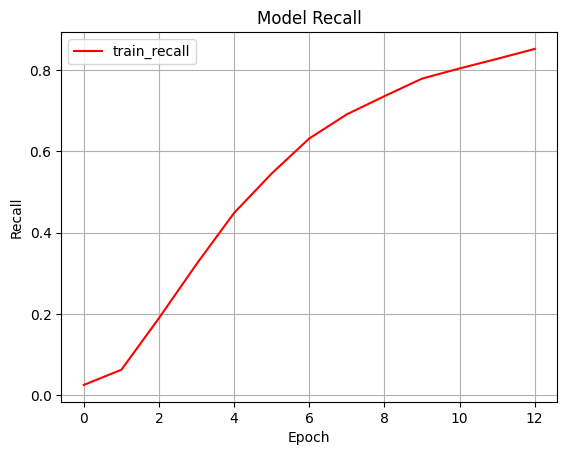

In [ ]:
train_precision = [0.4301, 0.6692, 0.8409, 0.8538, 0.8540, 0.8619, 0.8727, 0.8803, 0.8893, 0.8995, 0.9049, 0.9098, 0.9188]
train_recall = [0.0257, 0.0630, 0.1899, 0.3228, 0.4485, 0.5454, 0.6315, 0.6908, 0.7355, 0.7786, 0.8036, 0.8272, 0.8516]
# Создание графика для precision
plt.plot(train_precision, label='train_precision', color='green')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

# Создание графика для recall
plt.plot(train_recall, label='train_recall', color='red')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.plot(history.history['precision'], label='train_precision')
plt.plot(history.history['val_precision'], label='val_precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()


plt.plot(history.history['recall'], label='train_recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [ ]:

from sklearn.metrics import f1_score


final_precision = history.history['precision'][-1]
final_recall = history.history['recall'][-1]
final_accuracy = history.history['accuracy'][-1]


f1 = 2 * (final_precision * final_recall) / (final_precision + final_recall)


print("Final F1-score:", f1)
